# In this file we calibrate the rough Heston model through the pointwise random grids approach
In the forward pass we learn the **mapping** between **rough Heston parameters** and the option **implied volatility**, In this case the implied volatility surface is on an adaptive random grid 13(strikes)x11(maturities) a bit larger than the one used for the image based approach.

Below we upload the dataset which we created in the random grid data notebook, where you can find all the details.

In [1]:
#Set the directory of stored dataset
import os
os.chdir("C:/Users/pc/Desktop/politecnico/TESI/mio codice/rHeston/random grids")

In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
#Open compressed dataset

file_path = "rHestonflatRandomGridsDataset.csv"
df=pd.read_csv(file_path) #load data in a numpy array
clean_data = df.iloc[:, :6].values
xx = df.iloc[:, :4].values   #extract first 4 columns (rHeston parameters)
clean_ivs = df.iloc[:, 6].values

print("\nInput (rough Heston parameter sets) shape (samples × 4 parameters):", xx.shape)
print("  - Each row contains: [H, γ, ρ, ν₀]")
print("\nShape clean_data:", clean_data.shape)  # Should be (16000*143, 6)
print("\nShape clean_ivs:", clean_ivs.shape)    # Should be (16000*143,)
print("\nFirst 3 rows of clean data:")
print(clean_data[:3])
print("\nFirst 3 implied vols:")
print(clean_ivs[:3])


Input (rough Heston parameter sets) shape (samples × 4 parameters): (2288000, 4)
  - Each row contains: [H, γ, ρ, ν₀]

Shape clean_data: (2288000, 6)

Shape clean_ivs: (2288000,)

First 3 rows of clean data:
[[ 0.09988963  0.62535715 -0.26080363  0.07983231  0.9432724   0.01311258]
 [ 0.09988963  0.62535715 -0.26080363  0.07983231  0.96101277  0.01311258]
 [ 0.09988963  0.62535715 -0.26080363  0.07983231  0.96635666  0.01311258]]

First 3 implied vols:
[0.34896368 0.31626087 0.30632921]


# Let's have a look at the parameters sets and gain some more informations


=== HESTON PARAMETERS ANALYSIS (xx) ===
       H (Hurst exponent)  ν (vol of variance)  ρ (spot-vol correlation)  \
count          16000.0000           16000.0000                16000.0000   
mean               0.1299               0.3987                   -0.3999   
std                0.0691               0.1441                    0.1726   
min                0.0100               0.1500                   -0.7000   
1%                 0.0122               0.1555                   -0.6938   
5%                 0.0224               0.1756                   -0.6697   
50%                0.1299               0.3990                   -0.4000   
95%                0.2375               0.6240                   -0.1305   
99%                0.2474               0.6450                   -0.1066   
max                0.2500               0.6499                   -0.1000   

       ν₀ (initial variance)  
count             16000.0000  
mean                  0.0677  
std                   0.0362 

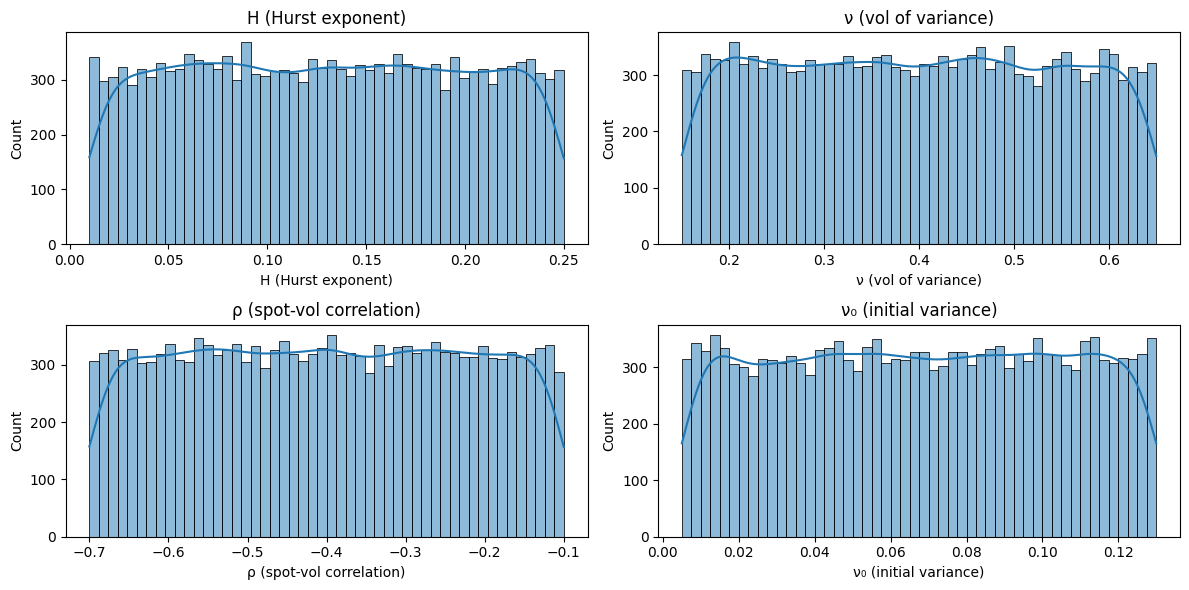

In [4]:
import seaborn as sns

#INPUT (rHESTON PARAMETERS) ANALYSIS 

# rHeston parameter names (for clarity)
#H     ∈ [0.01, 0.25]        (Hurst exponent)
#ν     ∈ [0.15, 0.65]        (vol of vol)
#ρ     ∈ [-0.7, -0.1]        (spot-vol correlation)
#ν₀    ∈ [0.005, 0.13]       (initial variance)

param_names = [
    'H (Hurst exponent)',
    'ν (vol of variance)',
    'ρ (spot-vol correlation)',
    'ν₀ (initial variance)'
]


# Create DataFrame for statistical analysis
df_xx = pd.DataFrame(xx[::143,:], columns=param_names)

# Descriptive statistics
print("\n=== HESTON PARAMETERS ANALYSIS (xx) ===")
print(df_xx.describe(percentiles=[0.01, 0.05, 0.95, 0.99]).round(4))

# Validate physical bounds
print("\n=== PHYSICAL BOUNDS ===")
print(f"ν₀:    Min={df_xx.iloc[:,3].min():.4f}, Max={df_xx.iloc[:,3].max():.4f} (Expected: ~[0.005, 0.13])")
print(f"ρ:   Min={df_xx.iloc[:,2].min():.4f}, Max={df_xx.iloc[:,2].max():.4f} (Expected: ~[-0.7, -0.1])")
print(f"H: Min={df_xx.iloc[:,0].min():.4f}, Max={df_xx.iloc[:,0].max():.4f} (Expected: ~[0.01, 0.25])")

# Plot distributions
plt.figure(figsize=(12, 6))
for i, col in enumerate(df_xx.columns):
    plt.subplot(2, 2, i+1)
    sns.histplot(df_xx[col], bins=50, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Step 1: Data Loading


## **Inputs:** 
###  1. $H$ Hurst exponent
###  2. $\gamma$ vol of variance
###  3. $\rho$ spot-vol correlation
###  4. $\nu_{0}$ inital variance
###  5. $K$ option strike price
###  6. $T$ option maturity
    
## **Output:**
### Option Implied volatility 

In [5]:
# RENAME DATASET
#===================================================================

random_grid_data = clean_data
implied_vols = clean_ivs

# Verify the first and last parameter sets:
print("\nFirst set parameters:", random_grid_data[0, :4])
print("Last set parameters:", random_grid_data[-143, :4])  # First row of last set


First set parameters: [ 0.09988963  0.62535715 -0.26080363  0.07983231]
Last set parameters: [ 0.17210251  0.25074558 -0.49241884  0.06870224]


# Train-val-test split
In the following snippet we perform the usual trainining-validation-test split, but we need to be careful, this split is not completely random. In fact we need to handle the dataset not at a single-option level, but to parameter set level, meaning that we need to **preserve the integrity** of each surface referring to a parameter set, ESPECIALLY on the test set, where we will calibrate each IV surface.

In [6]:
def split_parameter_blocks(X_pw, y_pw, points_per_sample=143, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, random_seed=42):
    """
    Splits the dataset into train/val/test sets while keeping all strike-maturity combinations
    for each rough Heston parameter set together (no mixing of parameter sets across splits).
    
    Args:
        X_pw: Pointwise features array (n_samples*n_points, 6) [H, γ, ρ, ν₀ ,strike,maturity]
        y_pw: Pointwise target array (n_samples*n_points,) [implied_vols]
        points_per_sample: Number of points per parameter set (default 143)
        train_ratio: Fraction of parameter sets for training
        val_ratio: Fraction of parameter sets for validation
        test_ratio: Fraction of parameter sets for testing
        random_seed: Optional random seed for reproducibility
        
    Returns:
        Tuple of (X_train, y_train), (X_val, y_val), (X_test, y_test)
    """
    # Verify ratios sum to 1
    assert np.isclose(train_ratio + val_ratio + test_ratio, 1.0), "Ratios must sum to 1"
    
    # Calculate number of unique parameter sets
    n_samples = len(X_pw) // points_per_sample
    assert len(X_pw) == n_samples * points_per_sample, "Data length doesn't match expected samples*points"
    
    print(f"Total parameter sets: {n_samples}")
    print(f"Points per parameter set: {points_per_sample}")
    print(f"Total points: {len(X_pw)}")
    
    # Create sample indices (0,0,0..., 1,1,1..., etc.)
    sample_indices = np.repeat(np.arange(n_samples), points_per_sample)
    
    # Split parameter set indices (not the points themselves)
    np.random.seed(random_seed)
    shuffled_indices = np.random.permutation(n_samples)
    
    train_end = int(n_samples * train_ratio)
    val_end = train_end + int(n_samples * val_ratio)
    
    train_samples = shuffled_indices[:train_end]
    val_samples = shuffled_indices[train_end:val_end]
    test_samples = shuffled_indices[val_end:]
    
    print(f"\nSplit counts:")
    print(f"Training parameter sets: {len(train_samples)} ({len(train_samples)/n_samples:.1%})")
    print(f"Validation parameter sets: {len(val_samples)} ({len(val_samples)/n_samples:.1%})")
    print(f"Test parameter sets: {len(test_samples)} ({len(test_samples)/n_samples:.1%})")
    
    # Create masks for each split
    train_mask = np.isin(sample_indices, train_samples)
    val_mask = np.isin(sample_indices, val_samples)
    test_mask = np.isin(sample_indices, test_samples)
    
    # Apply masks to get splits
    X_train, y_train = X_pw[train_mask], y_pw[train_mask]
    X_val, y_val = X_pw[val_mask], y_pw[val_mask]
    X_test, y_test = X_pw[test_mask], y_pw[test_mask]
    
    # Verification checks
    assert len(X_train) == len(train_samples) * points_per_sample
    assert len(X_val) == len(val_samples) * points_per_sample
    assert len(X_test) == len(test_samples) * points_per_sample
    
    # Verify no overlapping parameter sets between splits
    assert len(set(train_samples) & set(val_samples)) == 0
    assert len(set(train_samples) & set(test_samples)) == 0
    assert len(set(val_samples) & set(test_samples)) == 0
    
    print("\nVerification passed - all parameter sets remain intact in their respective splits")
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


# Example usage:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = \
    split_parameter_blocks(random_grid_data, implied_vols, points_per_sample=143,
                          train_ratio=0.8, val_ratio=0.1, test_ratio=0.1,
                          random_seed=42)

# Verification prints
print("\n=== Split Shapes ===")
print(f"Training set: {X_train.shape} (should be ~{len(random_grid_data)*0.8:.0f} points)")
print(f"Validation set: {X_val.shape} (should be ~{len(random_grid_data)*0.1:.0f} points)")
print(f"Test set: {X_test.shape} (should be ~{len(random_grid_data)*0.1:.0f} points)")

print("\n=== Sample Distribution ===")
print(f"First training sample params: {X_train[0][:4]}")
print(f"First validation sample params: {X_val[0][:4]}")
print(f"First test sample params: {X_test[0][:4]}")

Total parameter sets: 16000
Points per parameter set: 143
Total points: 2288000

Split counts:
Training parameter sets: 12800 (80.0%)
Validation parameter sets: 1600 (10.0%)
Test parameter sets: 1600 (10.0%)

Verification passed - all parameter sets remain intact in their respective splits

=== Split Shapes ===
Training set: (1830400, 6) (should be ~1830400 points)
Validation set: (228800, 6) (should be ~228800 points)
Test set: (228800, 6) (should be ~228800 points)

=== Sample Distribution ===
First training sample params: [ 0.09988963  0.62535715 -0.26080363  0.07983231]
First validation sample params: [ 0.04744447  0.22799726 -0.66514983  0.11327202]
First test sample params: [ 0.08301814  0.41237822 -0.44083299  0.04140364]


# Scaling:
Now we can finally scale both the parameters as shown below and the implied volatilities, this will improve the numerical stability of the training and calibration procedure.

# Model Parameters ${\theta}_{i=1,..,4}\to scale(\theta_i)\in[-1,1]$
## $scale(\theta_i)=\frac{2\theta_i-(\theta_i^{max}+\theta_i^{min})}{\theta_i^{max}-\theta_i^{min}},\quad i \in |\Theta|$

# Implied volatilities
## $$scale(\sigma^{BS}_{i,j})=\frac{\sigma^{BS}_{i,j}-\mathbb{E}[\sigma^{BS}_{i,j}]}{std(\sigma^{BS}_{i,j})},\quad i\in\text{Maturities},\; j\in \text{Strikes}$$

In [7]:
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate

# =================================================================
# 1. IMPLIED VOLATILITY SCALING (StandardScaler)
# =================================================================
scaler_yy = StandardScaler()

# Reshape y arrays to 2D if needed (StandardScaler expects 2D input)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Apply scaling
y_train_transform = scaler_yy.fit_transform(y_train)  # Compute μ and σ on training set
y_val_transform = scaler_yy.transform(y_val)          # Use same μ and σ
y_test_transform = scaler_yy.transform(y_test)        # Use same μ and σ

# Inverse transform function
def yinversetransform(y_scaled):
    """Convert scaled volatilities back to original scale"""
    return scaler_yy.inverse_transform(y_scaled)

# ========================================================================
#2-Custom [-1,1] rHeston parameter scaling, define rHeston parameter's upper and lower bounds
# ===============================================================================
#H     ∈ [0.01, 0.25]        (Hurst exponent)
#ν     ∈ [0.15, 0.65]        (initial variance)
#ρ     ∈ [-0.7, -0.1]        (spot-vol correlation)
#ν₀    ∈ [0.005, 0.13]       (vol of variance)

#parameters order is: [H, ν, ρ, ν₀]

ub=np.array([0.25,0.65,-0.1,0.13])
lb=np.array([0.01,0.15,-0.7,0.005])


def myscale(x):
    """
    Scale rHeston parameters to [-1,1] range while preserving strike/maturity
    Args:
        x: Input array (n_points, 6) where cols 0-3 are rHeston params, 4-5 are strike/maturity
    Returns:
        Scaled array with same shape, only rHeston params transformed
    """
    x_scaled = x.copy()
    # Only scale first 4 columns (rHeston params)
    for i in range(4):
        x_scaled[:,i] = (2*x[:,i] - (ub[i] + lb[i])) / (ub[i] - lb[i])
    return x_scaled

def myinverse(x_scaled):
    """
    Convert scaled rHeston params back to original scale
    Args:
        x_scaled: Scaled array (n_points, 6)
    Returns:
        Array with rHeston params in original scale
    """
    x_original = x_scaled.copy()
    for i in range(4):
        x_original[:,i] = x_scaled[:,i] * (ub[i] - lb[i]) * 0.5 + (ub[i] + lb[i]) * 0.5
    return x_original

# Apply scaling (only to Heston params, leave strike/maturity unchanged)
x_train_transform = myscale(X_train)
x_val_transform = myscale(X_val)
x_test_transform = myscale(X_test)

# =================================================================
# VERIFICATION
# =================================================================
def verify_scaling(original, scaled, param_names):
    """Check scaling was correctly applied"""
    print("\nScaling verification for:", param_names)
    for i in range(4):  # Only check rHeston params
        orig_min, orig_max = original[:,i].min(), original[:,i].max()
        scaled_min, scaled_max = scaled[:,i].min(), scaled[:,i].max()
        print(f"{param_names[i]:<6}: [{orig_min:.4f},{orig_max:.4f}] -> [{scaled_min:.4f},{scaled_max:.4f}]")
    
    # Verify strike/maturity unchanged
    assert np.allclose(original[:,4:], scaled[:,4:]), "Strike/maturity values were modified!"

print("=== Scaling Verification ===")
verify_scaling(X_train, x_train_transform, ["H", "ν", "ρ", "ν₀"])

# =================================================================
# DATASET SUMMARY
# =================================================================
shape_data = [
    ["Training", x_train_transform.shape, y_train_transform.shape],
    ["Validation", x_val_transform.shape, y_val_transform.shape], 
    ["Test", x_test_transform.shape, y_test_transform.shape]
]

print("\n=== Scaled Dataset Shapes ===")
print(tabulate(shape_data,
               headers=["Split", "Features Shape", "Target Shape"],
               tablefmt="grid",
               stralign="center"))

print("\nKey Notes:")
print("- Only Heston parameters (first 4 columns) were scaled to [-1,1] range")
print("- Strike and maturity values (last 2 columns) remain in original scale")
print("- Implied volatilities were standardized using z-score scaling")

=== Scaling Verification ===

Scaling verification for: ['H', 'ν', 'ρ', 'ν₀']
H     : [0.0100,0.2500] -> [-0.9998,0.9999]
ν     : [0.1500,0.6499] -> [-0.9999,0.9995]
ρ     : [-0.7000,-0.1000] -> [-1.0000,0.9999]
ν₀    : [0.0050,0.1300] -> [-1.0000,0.9998]

=== Scaled Dataset Shapes ===
+------------+------------------+----------------+
|   Split    |  Features Shape  |  Target Shape  |
+============+==================+================+
|  Training  |   (1830400, 6)   |  (1830400, 1)  |
+------------+------------------+----------------+
| Validation |   (228800, 6)    |  (228800, 1)   |
+------------+------------------+----------------+
|    Test    |   (228800, 6)    |  (228800, 1)   |
+------------+------------------+----------------+

Key Notes:
- Only Heston parameters (first 4 columns) were scaled to [-1,1] range
- Strike and maturity values (last 2 columns) remain in original scale
- Implied volatilities were standardized using z-score scaling


# CaNN: Calibration Neural Network
Step 1: *Forward Pass*
Now we can train the network to learn the **mapping** from: rHeston + **random** contract parameters -> implied volatility. we can set up our neural network composed of:

- **4 hidden layers**, each with **30 neurons**  
- **output layer** with 1 neuron, here we select a **linear** activation function because of the preprocessing of implied volatilities
- **Activation function**: **Elu** , $\sigma_{Elu}=\alpha(e^x -1)$ in all the layers, its smoothness is crucial for the approximation of the Loss function
- **Batch size**: **1024**  
- **Optimizer**: **Adam**  
- **Early stopping**: with patience set to 40 epochs, maximum number of epochs being 400
- **Loss**: MSE

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

# Set precision to float64
tf.keras.backend.set_floatx('float64')
tf.random.set_seed(42)  # For consistent initialization

# Build the model
inputs = Input(shape=(6,), name='input_layer')
x1 = Dense(30, activation='elu', name='hidden_1')(inputs)
x2 = Dense(30, activation='elu', name='hidden_2')(x1) 
x3 = Dense(30, activation='elu', name='hidden_3')(x2) 
x4 = Dense(30, activation='elu', name='hidden_4')(x3)
outputs = Dense(1, activation='linear', name='output_layer')(x4)

modelrandom = Model(inputs=inputs, outputs=outputs, name = 'random_point_model')
modelrandom.summary()

Model: "random_point_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_1 (Dense)                │ (None, 30)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_4 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,031 (23.68 KB)

 Trainable params: 3,031 (23.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/400
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.1146 - val_loss: 0.0134
Epoch 2/400
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0101 - val_loss: 0.0062
Epoch 3/400
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0047 - val_loss: 0.0029
Epoch 4/400
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 5/400
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 6/400
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 7/400
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 9.7373e-04 - val_loss: 8.1380e-04
Epoch 8/400
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 8.1116e-04 - val_loss: 6.6676e-04
Epoch 9/400
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 7.0257e-04 - val_loss: 5.6914e-04
Epoch 10/400
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 6.2339e-04 - val_loss: 4.9870e-04
Epoch 11/400
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 5.6146e-04 -

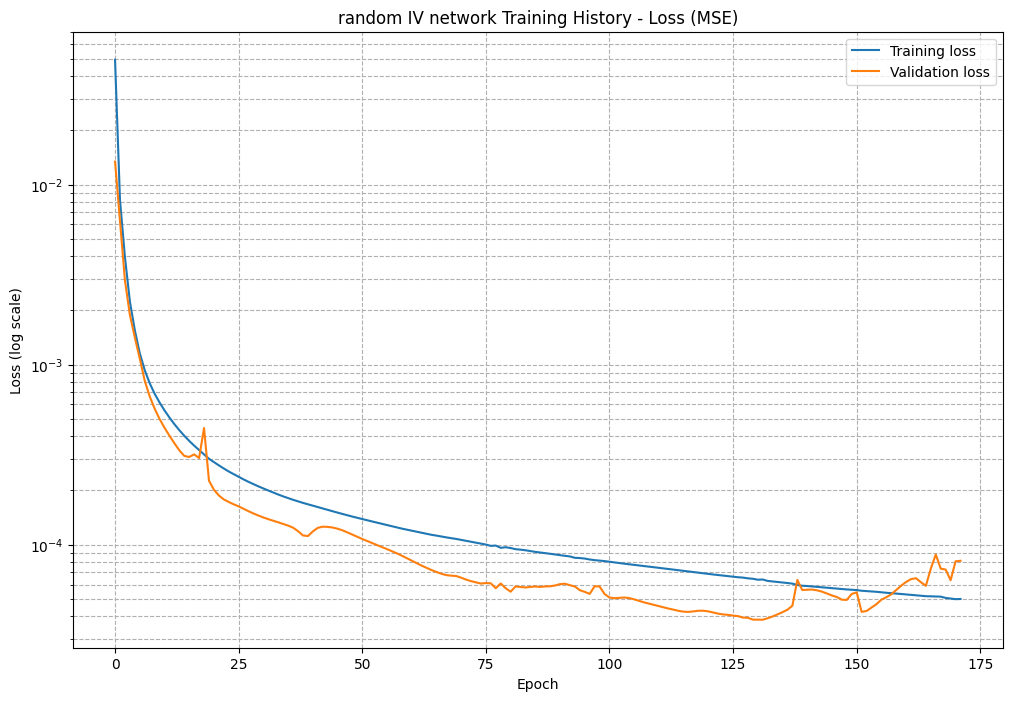


Final Training Loss: 4.9870e-05
Final Validation Loss: 8.1265e-05


In [9]:
import time
# EarlyStopping callback
earlystop = EarlyStopping(
    monitor='val_loss', 
    patience=40,       
    verbose=1,       
    restore_best_weights=True  # Restore the best model weights
)

# Callbacks
#reduce_lr = ReduceLROnPlateau(
#        monitor='val_loss',
#        factor=0.5,
#        patience=20,
#        min_lr=5e-5,
 #       verbose=1
 #   )

# Compile the model
modelrandom.compile(loss="mse", optimizer="adam")

# Train the model
start=time.time()
history = modelrandom.fit(
    x_train_transform, 
    y_train_transform, 
    batch_size=1024,
    validation_data=(x_val_transform, y_val_transform),
    epochs=400, 
    verbose=1, 
    shuffle=True, 
    callbacks=[earlystop]
)
end=time.time()
training_time=(end-start)
print("Training time :" ,training_time , "s" )

# Plot training history
plt.figure(figsize=(12, 8))  
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.yscale('log')
plt.title('random IV network Training History - Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

# Print final metrics
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"\nFinal Training Loss: {final_train_loss:.4e}")
print(f"Final Validation Loss: {final_val_loss:.4e}")

# Evaluate the map on test data

7150/7150 ━━━━━━━━━━━━━━━━━━━━ 7s 937us/step

=== Performance on Standardized Scale ===
- MSE: 0.000038
- RMSE: 0.006162
- MAE: 0.004316

=== Performance on Original Scale ===
- MSE: 0.0000003
- RMSE: 0.000518 (0.21% of mean IV)
- MAE: 0.000363 (0.15% of mean IV)


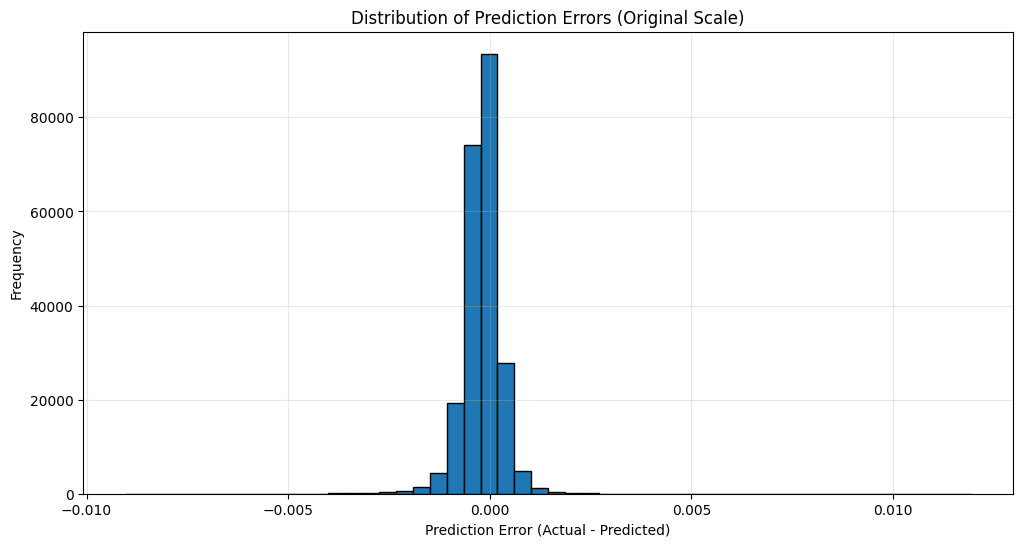

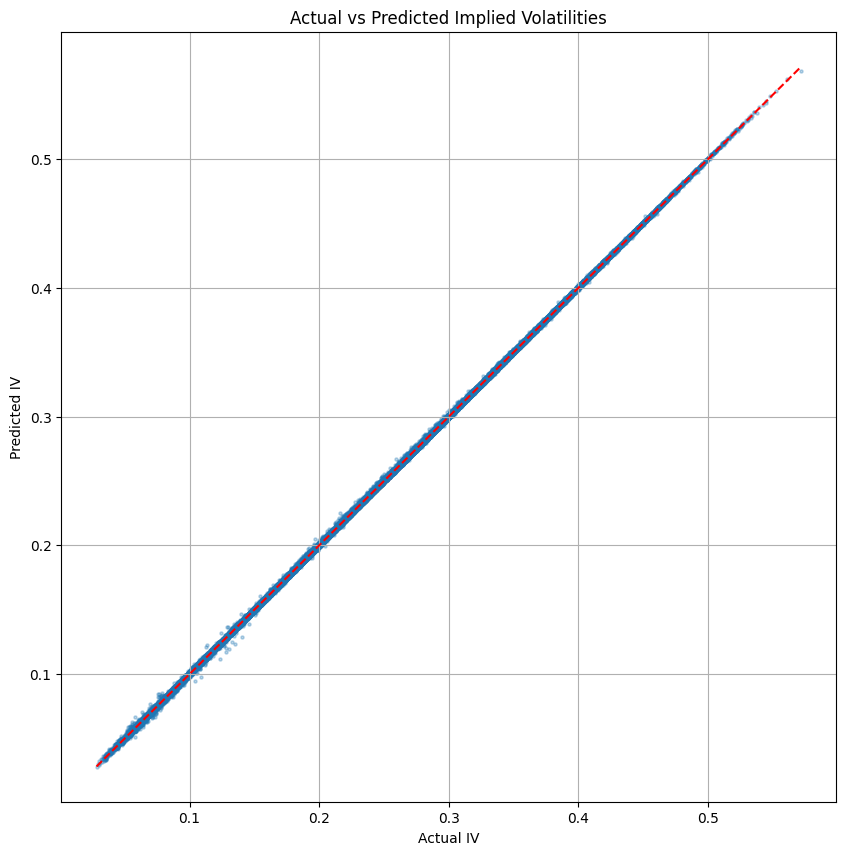

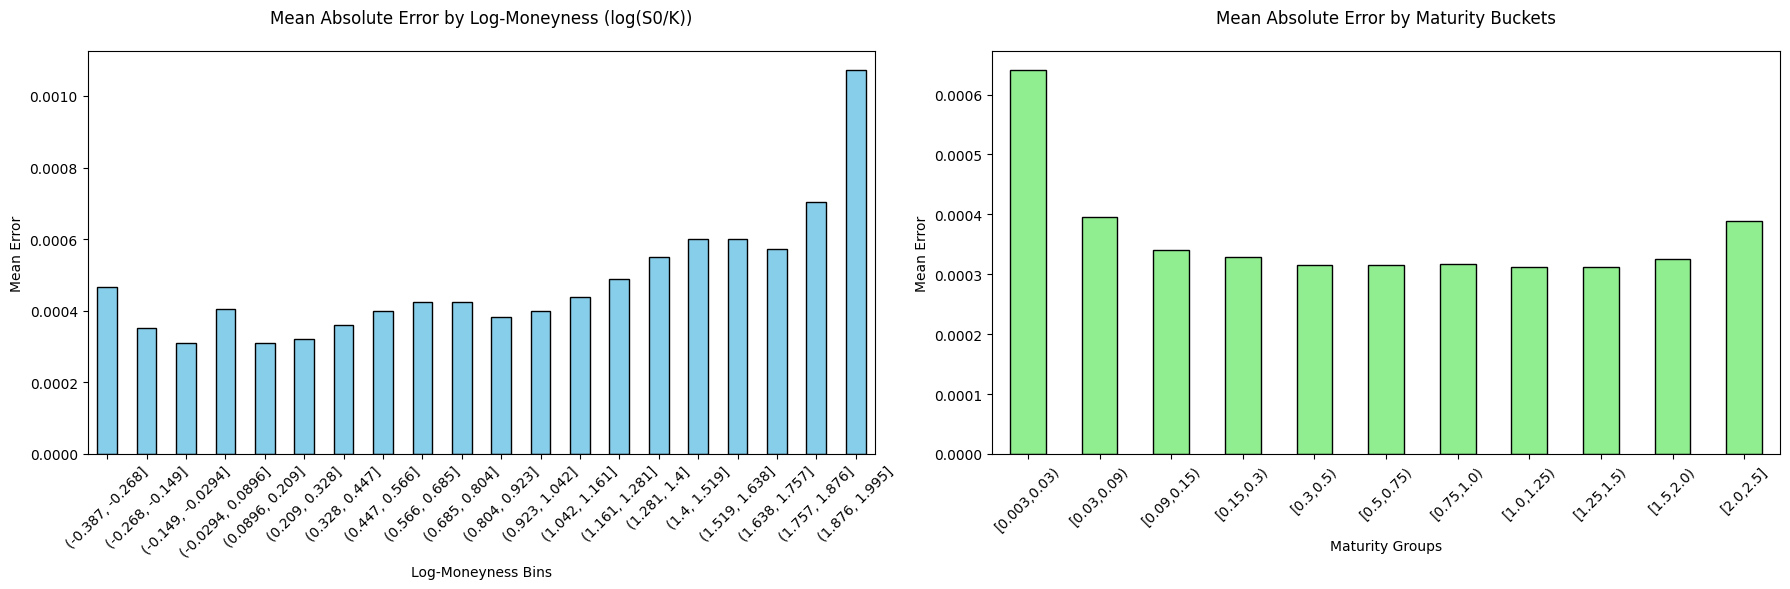


=== MAE by Maturity Bucket ===
[0.003,0.03): 0.000641
[0.03,0.09): 0.000396
[0.09,0.15): 0.000341
[0.15,0.3): 0.000328
[0.3,0.5): 0.000315
[0.5,0.75): 0.000316
[0.75,1.0): 0.000316
[1.0,1.25): 0.000313
[1.25,1.5): 0.000313
[1.5,2.0): 0.000326
[2.0,2.5]: 0.000388


In [10]:
# Calculate predictions on test set
y_pred_transformed = modelrandom.predict(x_test_transform, verbose=1)

# 1) Evaluation on transformed scale (standardized volatilities)
mse_transformed = np.mean(np.square(y_test_transform - y_pred_transformed))
rmse_transformed = np.sqrt(mse_transformed)
mae_transformed = np.mean(np.abs(y_test_transform - y_pred_transformed))

print("\n=== Performance on Standardized Scale ===")
print(f"- MSE: {mse_transformed:.6f}")
print(f"- RMSE: {rmse_transformed:.6f}")
print(f"- MAE: {mae_transformed:.6f}")

# 2) Evaluation on original scale (implied volatilities)
y_pred_original = yinversetransform(y_pred_transformed)

mse_original = np.mean(np.square(y_test - y_pred_original))
rmse_original = np.sqrt(mse_original)
mae_original = np.mean(np.abs(y_test - y_pred_original))
mean_iv = np.mean(y_test)  # Reference for relative error

print("\n=== Performance on Original Scale ===")
print(f"- MSE: {mse_original:.7f}")
print(f"- RMSE: {rmse_original:.6f} ({(rmse_original/mean_iv)*100:.2f}% of mean IV)")
print(f"- MAE: {mae_original:.6f} ({(mae_original/mean_iv)*100:.2f}% of mean IV)")

# 3) Error distribution analysis
errors = y_test - y_pred_original
plt.figure(figsize=(12, 6))
plt.hist(errors, bins=50, edgecolor='black')
plt.title('Distribution of Prediction Errors (Original Scale)')
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# 4) Scatter plot of predictions vs actual
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred_original, alpha=0.3, s=5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Implied Volatilities')
plt.xlabel('Actual IV')
plt.ylabel('Predicted IV')
plt.grid(True)
plt.show()

# 5) Error by moneyness and maturity (adapted version without df_test)
S0=1.0
log_moneyness = np.log(S0 / X_test[:, 4]) 
maturities = X_test[:, 5] 

# Define maturity buckets exactly as in random grid generation
maturity_bins = [0.003, 0.03, 0.09, 0.15, 0.3, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 2.5]
maturity_labels = [
    '[0.003,0.03)', '[0.03,0.09)', '[0.09,0.15)', '[0.15,0.3)',
    '[0.3,0.5)', '[0.5,0.75)', '[0.75,1.0)', '[1.0,1.25)',
    '[1.25,1.5)', '[1.5,2.0)', '[2.0,2.5]'
]

# Create moneyness bins (20 equally spaced bins between min and max)
moneyness_bins = np.linspace(log_moneyness.min(), log_moneyness.max(), 21)

# Calculate mean errors
moneyness_groups = pd.cut(log_moneyness, bins=moneyness_bins)
maturity_groups = pd.cut(maturities, bins=maturity_bins, labels=maturity_labels)

mae = np.abs(errors).reshape(-1)
error_by_moneyness = pd.Series(mae).groupby(moneyness_groups).mean()
error_by_maturity = pd.Series(mae).groupby(maturity_groups).mean()

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Moneyness plot
error_by_moneyness.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Mean Absolute Error by Log-Moneyness (log(S0/K))', pad=20)
ax1.set_xlabel('Log-Moneyness Bins')
ax1.set_ylabel('Mean Error')
ax1.tick_params(axis='x', rotation=45)

# Maturity plot
error_by_maturity.plot(kind='bar', ax=ax2, color='lightgreen', edgecolor='black')
ax2.set_title('Mean Absolute Error by Maturity Buckets', pad=20)
ax2.set_xlabel('Maturity Groups')
ax2.set_ylabel('Mean Error')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Additional: Print MAE for each maturity bucket
print("\n=== MAE by Maturity Bucket ===")
for maturity, mae in error_by_maturity.items():
    print(f"{maturity}: {mae:.6f}")

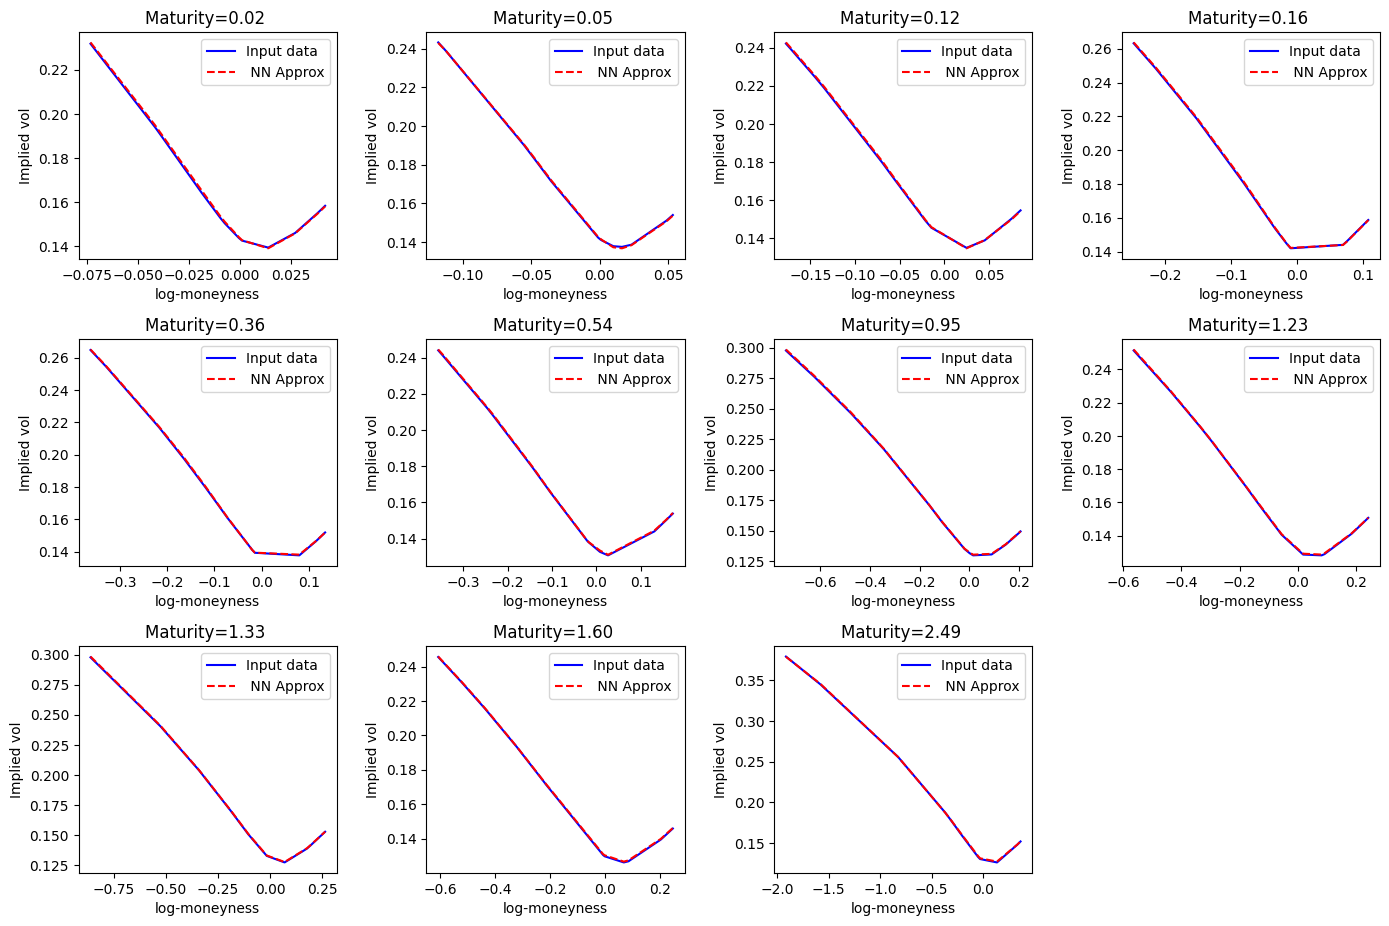

In [10]:
# FINALLY WE PLOT SAMPLE SMILES OF THE TEST SET

# Take a sample index from the test set
sample_ind = 512*143
sample_X = X_test[sample_ind:sample_ind+143]  # Get corresponding X_test rows
y_sample = y_test[sample_ind:sample_ind+143].squeeze().T             #take corresponding (not processed)test sample
prediction = y_pred_original[sample_ind:sample_ind+143].squeeze().T  #take corresponding (converted)prediction

S0=1.0  #specify spot price
strikes_dim = 13
maturities_dim = 11

plt.figure(1,figsize=(14,12))
for i in range(maturities_dim):
    plt.subplot(4,4,i+1)
    
    plt.plot(np.log(sample_X[i*strikes_dim:(i+1)*strikes_dim,4]/S0),y_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    plt.plot(np.log(sample_X[i*strikes_dim:(i+1)*strikes_dim,4]/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")

    
    plt.title("Maturity=%1.2f "%sample_X[i*strikes_dim,5])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.show()

# Optimizing the training
Numpy Implementation of the Neural Network tends to be faster than Keras

In [11]:
import scipy.optimize

# =====================================================================================
# EXTRACT TRAINED WEIGHTS FROM KERAS MODEL
# =====================================================================================

def extract_weights_from_keras_model(model):
    weights_and_biases = []
    for layer in model.layers:
        if hasattr(layer, 'get_weights') and layer.get_weights():
            weights, biases = layer.get_weights()
            weights_and_biases.append([weights, biases])
    return weights_and_biases

NNParameters = extract_weights_from_keras_model(modelrandom)

# =====================================================================================
# NUMPY IMPLEMENTATION OF THE NN AND GRADIENT
# =====================================================================================

NumLayers = 4  # Number of hidden layers

def elu(x):
    mask = x < 0
    out = x.copy()
    out[mask] = np.exp(out[mask]) - 1
    return out

def eluPrime(x):
    out = np.ones_like(x)
    mask = x < 0
    out[mask] = np.exp(x[mask])
    return out

def NeuralNetwork(x, strike, maturity):
    full_input = np.concatenate([x, [strike, maturity]])
    input1 = full_input

    for i in range(NumLayers):
        z = input1 @ NNParameters[i][0] + NNParameters[i][1]
        input1 = elu(z)

    output = input1 @ NNParameters[NumLayers][0] + NNParameters[NumLayers][1]
    return output.flatten()[0]

def NeuralNetworkGradient(x, strike, maturity):
    """
    Compute network gradient w.r.t. rHeston parameters only
    Input:
        heston_params - array of 4 scaled rHeston parameters
        strike - strike price (fixed)
        maturity - time to maturity (fixed)
    Output: Gradient vector of dimension (4,) - only w.r.t. rHeston params
    """
    # Concatenate full input
    full_input = np.concatenate([x, [strike, maturity]])
    
    # Forward pass with intermediate storage
    activations = [full_input.copy()]
    z_values = []
    
    input1 = full_input.copy()
    
    # Forward pass through hidden layers
    for i in range(NumLayers):
        z = np.dot(input1, NNParameters[i][0]) + NNParameters[i][1]
        input1 = elu(z)
        z_values.append(z)
        activations.append(input1.copy())
    
    # Output layer
    i += 1
    z_out = np.dot(input1, NNParameters[i][0]) + NNParameters[i][1]
    
    # Backward pass - start from output
    # Initialize gradient w.r.t. full input (6 dimensions)
    grad_full = np.zeros(6)
    
    # Output layer gradient (linear activation, so derivative = 1)
    delta = np.ones(1)  # Scalar output
    
    # Gradient w.r.t. last hidden layer
    grad_hidden = delta.dot(NNParameters[NumLayers][0].T)
    
    # Backpropagate through hidden layers
    for i in reversed(range(NumLayers)):
        # Gradient w.r.t. pre-activation
        grad_z = grad_hidden * eluPrime(z_values[i])
        
        # Gradient w.r.t. input of this layer
        if i == 0:
            # First layer - gradient w.r.t. network input
            grad_full = grad_z.dot(NNParameters[i][0].T)
        else:
            # Hidden layer - gradient w.r.t. previous activation
            grad_hidden = grad_z.dot(NNParameters[i][0].T)
    
    # Return only gradients w.r.t. rHeston parameters (first 4 elements)
    return grad_full[:4]


In [12]:
from typing import Tuple

# =====================================================================================
# PARAMETER SCALING UTILITIES
# =====================================================================================

def unscale_rheston_params(scaled_params: np.ndarray) -> np.ndarray:
    """Convert scaled parameters back to original scale"""
    return scaled_params * (ub - lb) * 0.5 + (ub + lb) * 0.5

# =====================================================================================
# SURFACE COST FUNCTION AND GRADIENT (VECTORIZED)
# =====================================================================================

def surface_cost_function(scaled_params: np.ndarray, 
                          strikes: np.ndarray, 
                          maturities: np.ndarray, 
                          market_ivs: np.ndarray) -> tuple[float, np.ndarray]:

    n_points = len(strikes)
    # Prepare input batch
    batch_input = np.column_stack([
        np.tile(scaled_params, (n_points, 1)),
        strikes.reshape(-1, 1),
        maturities.reshape(-1, 1)
    ])

    # Forward pass vectorized
    activations = batch_input.copy()
    for i in range(NumLayers):
        z = activations @ NNParameters[i][0] + NNParameters[i][1]
        activations = elu(z)
    
    outputs = activations @ NNParameters[NumLayers][0] + NNParameters[NumLayers][1]
    outputs = outputs.flatten()

    # Loss
    residuals = outputs - market_ivs
    total_loss = np.sum(residuals**2)

    # Gradient
    total_gradient = np.zeros_like(scaled_params)
    for i in range(n_points):
        grad = NeuralNetworkGradient(scaled_params, strikes[i], maturities[i])
        total_gradient += 2 * residuals[i] * grad

    return total_loss, total_gradient

In [13]:
# Initialize arrays
n_surfaces = 1600
n_methods = 4
n_params = 4

methods = ["L-BFGS-B", "SLSQP", "BFGS", "Levenberg-Marquardt"]
init_guess = np.zeros(4)  # Initial guess in [-1,1] scaled space
bounds = [(-1, 1)] * 4

# Prepare calibration data
calibration_data = []
for i in range(n_surfaces):
    start_idx = i * 143
    end_idx = (i+1) * 143
    strikes = x_test_transform[start_idx:end_idx, 4]
    maturities = x_test_transform[start_idx:end_idx, 5]
    market_ivs = y_test_transform[start_idx:end_idx, 0]
    calibration_data.append((strikes, maturities, market_ivs))

# Main calibration loop

# =====================================================================================
# OPTIMIZATION LOOP
# =====================================================================================

solutions = np.zeros((n_surfaces, n_methods, n_params))  # [surface, method, param]
times = np.zeros((n_surfaces, n_methods))

# Main calibration loop
for surface_idx in range(n_surfaces):
    print(f"Calibrating surface {surface_idx+1}/{n_surfaces}", end="\r")
    strikes, maturities, market_ivs = calibration_data[surface_idx]

    def fun(x):
        loss, _ = surface_cost_function(x, strikes, maturities, market_ivs)
        return loss

    def jac(x):
        _, grad = surface_cost_function(x, strikes, maturities, market_ivs)
        return grad

    def ls_fun(x):
        n = len(strikes)
        return np.array([
            NeuralNetwork(x, strikes[i], maturities[i]) - market_ivs[i]
            for i in range(n)
        ])

    def ls_jac(x):
        n = len(strikes)
        J = np.zeros((n, 4))
        for i in range(n):
            J[i, :] = NeuralNetworkGradient(x, strikes[i], maturities[i])
        return J

    # L-BFGS-B
    t0 = time.perf_counter()
    res = scipy.optimize.minimize(fun, init_guess, method='L-BFGS-B', jac=jac,
                                    bounds=bounds, tol=1e-10, options={"maxiter": 5000})
    t1 = time.perf_counter()
    solutions[surface_idx, 0, :] = unscale_rheston_params(res.x)
    times[surface_idx, 0] = t1 - t0

    # SLSQP
    t0 = time.perf_counter()
    res = scipy.optimize.minimize(fun, init_guess, method='SLSQP', jac=jac,
                                    bounds=bounds, tol=1e-10, options={"maxiter": 5000})
    t1 = time.perf_counter()
    solutions[surface_idx, 1, :] = unscale_rheston_params(res.x)
    times[surface_idx, 1] = t1 - t0

    # BFGS
    t0 = time.perf_counter()
    res = scipy.optimize.minimize(fun, init_guess, method='BFGS', jac=jac,
                                    tol=1e-10, options={"maxiter": 5000})
    t1 = time.perf_counter()
    solutions[surface_idx, 2, :] = unscale_rheston_params(res.x)
    times[surface_idx, 2] = t1 - t0

    # Levenberg-Marquardt
    t0 = time.perf_counter()
    res = scipy.optimize.least_squares(ls_fun, init_guess, jac=ls_jac,
                                        gtol=1e-10)
    t1 = time.perf_counter()
    solutions[surface_idx, 3, :] = unscale_rheston_params(res.x)
    times[surface_idx, 3] = t1 - t0

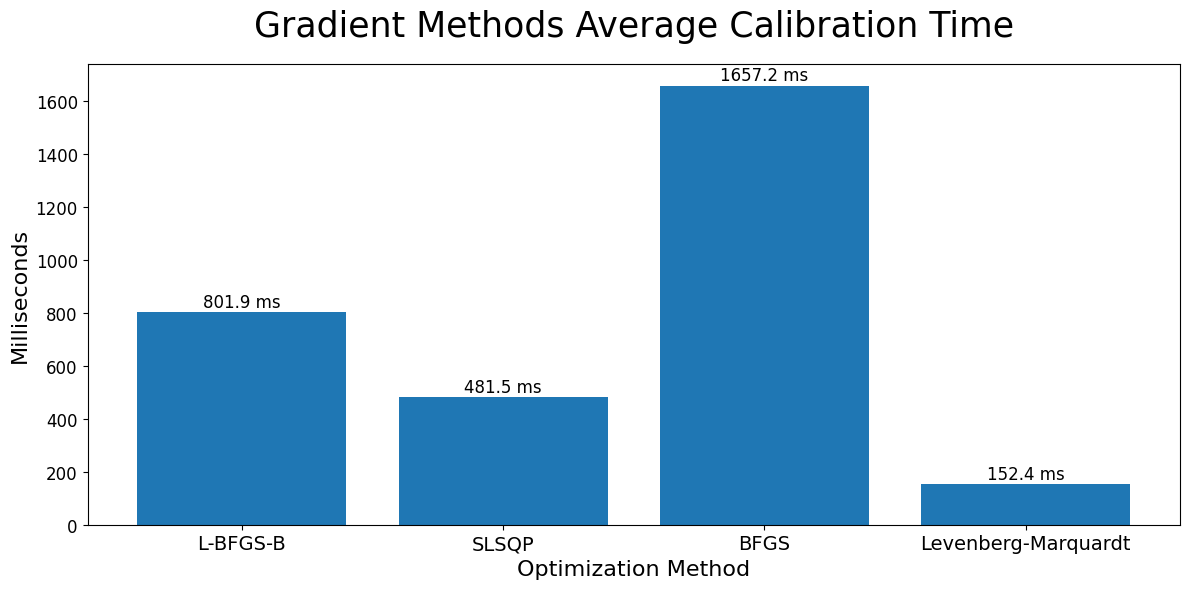

In [14]:
# =====================================================================================
# RESULTS ANALYSIS AND VISUALIZATION
# =====================================================================================

# Calculate average times in milliseconds
avg_times_ms = np.mean(times, axis=0) * 1000

# Plot settings
plt.figure(1, figsize=(12, 6))
bars = plt.bar(methods, avg_times_ms)

# Add exact numerical values above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{height:.1f} ms',
             ha='center', va='bottom', fontsize=12)

# Formatting
plt.title("Gradient Methods Average Calibration Time", fontsize=25, pad=20)
plt.ylabel("Milliseconds", fontsize=16)
plt.xlabel("Optimization Method", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

# Adjust layout to prevent text clipping
plt.tight_layout()
plt.show()

Calibrated parameters shape: (1600, 4)
Test parameters shape: (1600, 4)


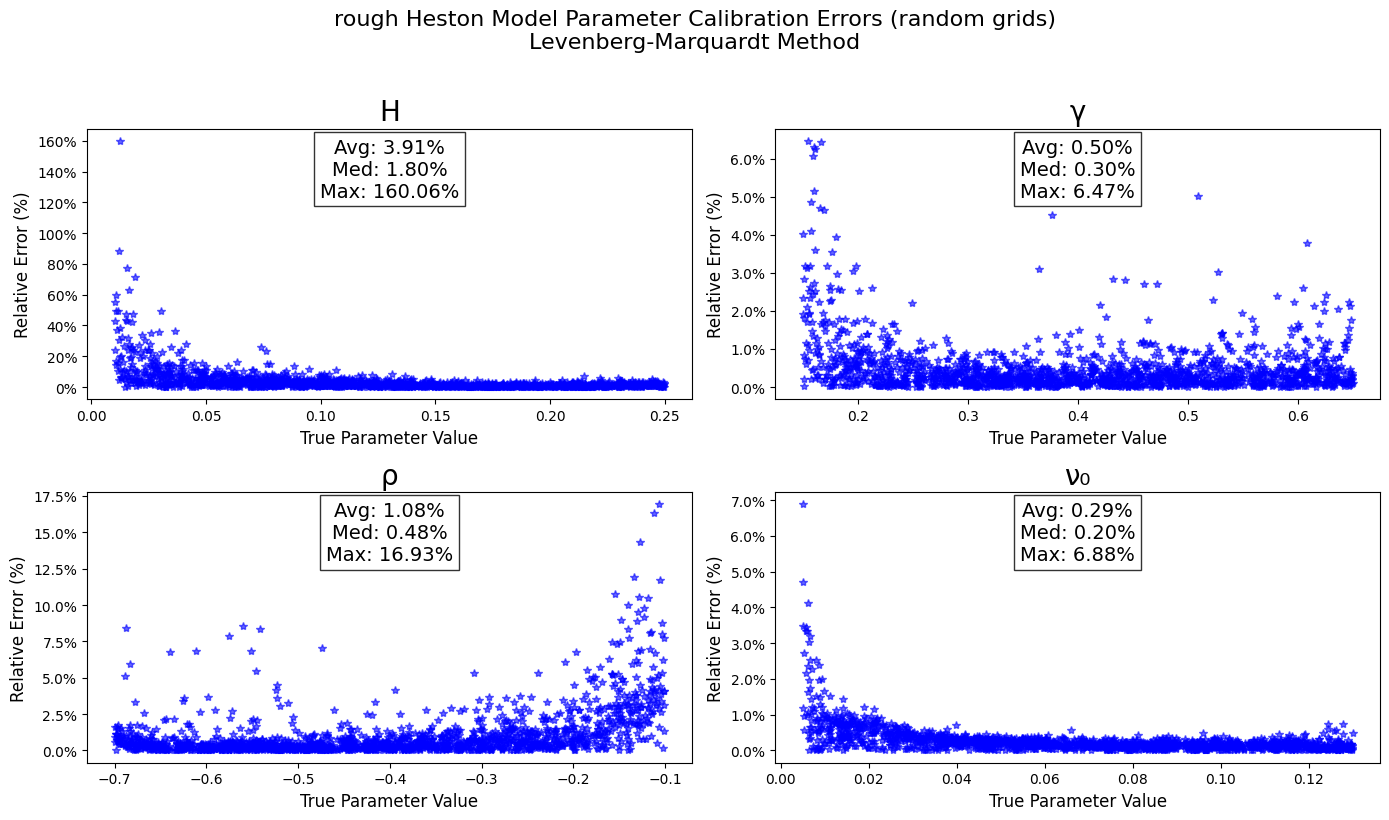


Summary Statistics of Relative Errors (%):
H: Avg=3.91%, Med=1.80%, Max=160.06%
γ: Avg=0.50%, Med=0.30%, Max=6.47%
ρ: Avg=1.08%, Med=0.48%, Max=16.93%
ν₀: Avg=0.29%, Med=0.20%, Max=6.88%


In [15]:
# Extract Levenberg-Marquardt parameters (usually the best performing)
LMParameters = solutions[:, 3, :]

# Extract unique Heston parameters from X_test (remove duplicates and strike/maturity columns)
# Since parameters are repeated 143 times for each surface, we take every 143th row
X_test_compare = X_test[::143, :4]  # Take every 143th row and first 4 columns

# Verify shapes
print(f"Calibrated parameters shape: {LMParameters.shape}")  # Should be (1600, 4)
print(f"Test parameters shape: {X_test_compare.shape}")      # Should be (1600, 4)

# Verify dimensions
assert len(LMParameters) == len(X_test_compare), "Mismatch between calibrated parameters and test set"

# Plot relative errors for each parameter
titles = ["H", "γ", "ρ", "ν₀"]
relative_errors = np.zeros((len(LMParameters), 4))  # Store all relative errors

fig = plt.figure(figsize=(14, 8))
for param_idx in range(4):
    ax = plt.subplot(2, 2, param_idx+1)
    
    # Get true and calibrated parameters
    true_params = X_test_compare[:len(LMParameters), param_idx]
    calibrated_params = LMParameters[:, param_idx]
    
    # Calculate relative errors 
    with np.errstate(divide='ignore', invalid='ignore'):
        rel_errors = np.abs(calibrated_params - true_params) / np.abs(true_params)
    
    relative_errors[:, param_idx] = rel_errors
    
    # Plot
    plt.plot(true_params, 100 * rel_errors, 'b*', alpha=0.6)
    plt.title(titles[param_idx], fontsize=20)
    plt.xlabel('True Parameter Value', fontsize=12)
    plt.ylabel('Relative Error (%)', fontsize=12)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    
    # Add statistics
    stats_text = 'Avg: %1.2f%%\nMed: %1.2f%%\nMax: %1.2f%%' % (
        np.mean(100 * rel_errors),
        np.median(100 * rel_errors),
        np.max(100 * rel_errors))
    
    plt.text(0.5, 0.85, stats_text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8))

plt.suptitle('rough Heston Model Parameter Calibration Errors (random grids)\nLevenberg-Marquardt Method', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Additional analysis
print("\nSummary Statistics of Relative Errors (%):")
for i, title in enumerate(titles):
    print(f"{title}: Avg={np.mean(100*relative_errors[:,i]):.2f}%, "
          f"Med={np.median(100*relative_errors[:,i]):.2f}%, "
          f"Max={np.max(100*relative_errors[:,i]):.2f}%")

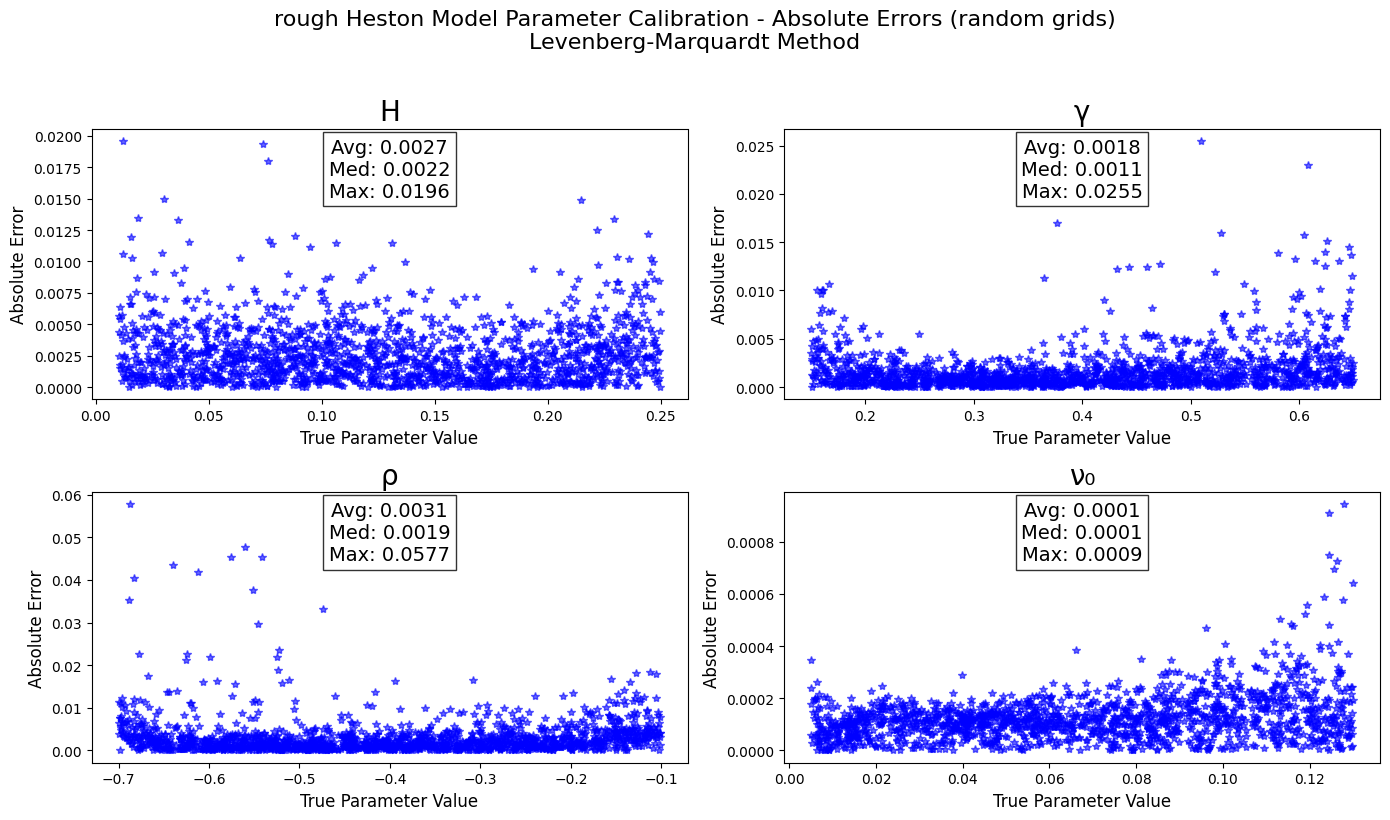


Summary Statistics of Absolute Errors:
H: Avg=0.002689, Med=0.002163, Max=0.019602
γ: Avg=0.001793, Med=0.001125, Max=0.025499
ρ: Avg=0.003125, Med=0.001934, Max=0.057750
ν₀: Avg=0.000126, Med=0.000114, Max=0.000944


In [16]:
# Correct parameter names and absolute error analysis
absolute_errors = np.zeros((len(LMParameters), 4))  # Store all absolute errors

fig = plt.figure(figsize=(14, 8))
for param_idx in range(4):
    ax = plt.subplot(2, 2, param_idx+1)
    
    # Get true and calibrated parameters
    true_params = X_test_compare[:len(LMParameters), param_idx]
    calibrated_params = LMParameters[:, param_idx]
    
    # Calculate absolute errors
    abs_errors = np.abs(calibrated_params - true_params)
    absolute_errors[:, param_idx] = abs_errors
    
    # Plot
    plt.plot(true_params, abs_errors, 'b*', alpha=0.6)
    plt.title(titles[param_idx], fontsize=20)
    plt.xlabel('True Parameter Value', fontsize=12)
    plt.ylabel('Absolute Error', fontsize=12)
    
    # Add statistics
    stats_text = 'Avg: %1.4f\nMed: %1.4f\nMax: %1.4f' % (
        np.mean(abs_errors),
        np.median(abs_errors),
        np.max(abs_errors))
    
    plt.text(0.5, 0.85, stats_text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8))

plt.suptitle('rough Heston Model Parameter Calibration - Absolute Errors (random grids)\nLevenberg-Marquardt Method', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Additional analysis
print("\nSummary Statistics of Absolute Errors:")
for i, title in enumerate(titles):
    print(f"{title}: Avg={np.mean(absolute_errors[:,i]):.6f}, "
          f"Med={np.median(absolute_errors[:,i]):.6f}, "
          f"Max={np.max(absolute_errors[:,i]):.6f}")

# Gradient-free optimization
And here we will exploit 3 different gradient free optimization methods: **COBYLA**, **Differential Evolution** and **Nelder-Mayer**.
We will use this configuration of parameters for these algorithms and compare both accuracy and calibration time.

In [17]:
# =====================================================================================
# GRADIENT-FREE CALIBRATION WITH DIFFERENT ALGORITHMS
# =====================================================================================

# Define parameter bounds in scaled space [-1, 1] for all parameters
bounds_scaled = [(-1, 1) for _ in range(4)]

# Initialize arrays for results
n_surfaces = 100
n_methods = 3
n_params = 4

solutions_gf = np.zeros((n_surfaces, n_methods, n_params))  # [surface, method, param]
times_gf = np.zeros((n_surfaces, n_methods))

methods = ["COBYLA", "Differential Evolution", "Nelder-Mead"]
init_guess = np.zeros(4)  # Initial guess in [-1,1] scaled space

print("Starting Gradient-Free Calibration...")
print(f"Total surfaces to calibrate: {n_surfaces}")

# Main calibration loop
for surface_idx in range(n_surfaces):
    print(f"Calibrating surface {surface_idx+1}/{n_surfaces}", end="\r")
    strikes, maturities, market_ivs = calibration_data[surface_idx]
    
    # Define cost function for this surface, same as before without the gradient (note: it takes directly the current market data being inside the loop, no need to pass them)
    def fun(x):
        loss, _ = surface_cost_function(x, strikes, maturities, market_ivs)
        return loss
    
    # COBYLA (Constrained Optimization BY Linear Approximation)
    start = time.perf_counter()
    result = scipy.optimize.minimize(
        fun,
        x0=init_guess,
        method='COBYLA',
        bounds=bounds_scaled,
        options={
            "maxiter": 5000,
            "disp": False,
            "catol": 1e-8,
            "tol": 1e-10
        }
    )
    solutions_gf[surface_idx, 0, :] = unscale_rheston_params(result.x)
    times_gf[surface_idx, 0] = time.perf_counter() - start
    
    # Differential Evolution
    start = time.perf_counter()
    result = scipy.optimize.differential_evolution(
        fun,
        bounds=bounds_scaled,
        popsize=50,
        strategy='best1bin',
        mutation=0.65,
        recombination=0.7,
        tol=0.01,
        maxiter=1000,
        disp=False,
        seed=42
    )
    solutions_gf[surface_idx, 1, :] = unscale_rheston_params(result.x)
    times_gf[surface_idx, 1] = time.perf_counter() - start
    
    # Nelder-Mead (Simplex method)
    start = time.perf_counter()
    result = scipy.optimize.minimize(
        fun,
        x0=init_guess,
        method='Nelder-Mead',
        options={
            "maxiter": 5000,
            "maxfev": 10000,
            "disp": False,
            "xatol": 1e-8,
            "fatol": 1e-10,
            "adaptive": True
        }
    )
    solutions_gf[surface_idx, 2, :] = unscale_rheston_params(result.x)
    times_gf[surface_idx, 2] = time.perf_counter() - start

print("\nGradient-Free Calibration completed!")

Starting Gradient-Free Calibration...
Total surfaces to calibrate: 100
Calibrating surface 100/100
Gradient-Free Calibration completed!


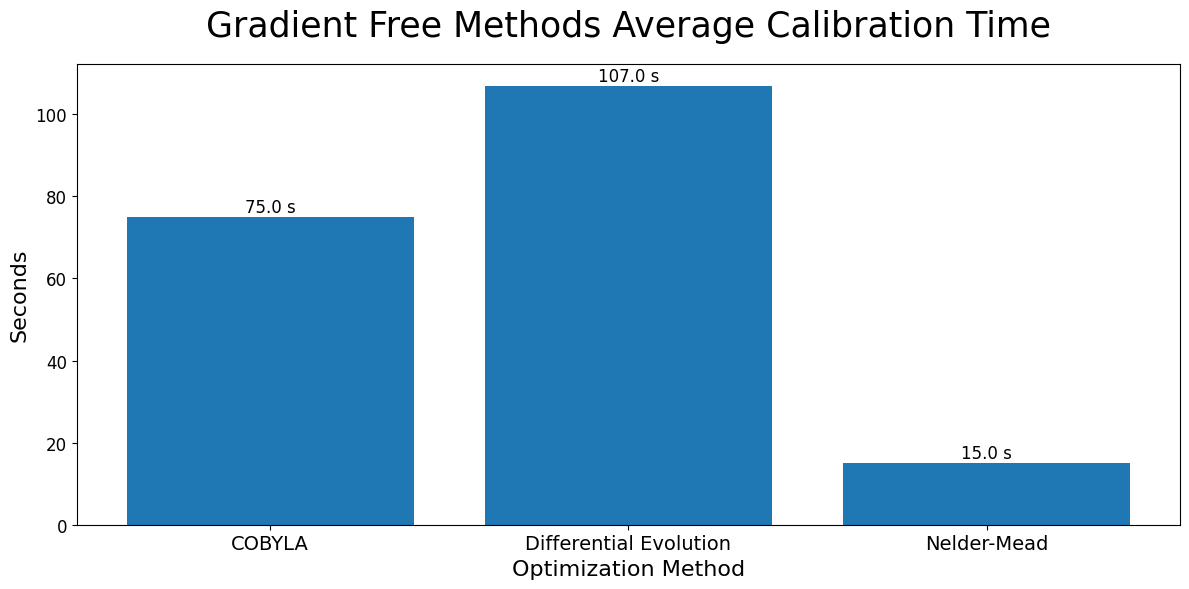

In [18]:
# =====================================================================================
# RESULTS ANALYSIS AND VISUALIZATION
# =====================================================================================

# Calculate average times in milliseconds
avg_times_ms = np.mean(times_gf, axis=0)

# Plot settings
plt.figure(1, figsize=(12, 6))
bars = plt.bar(methods, avg_times_ms)

# Add exact numerical values above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.25,
             f'{height:.1f} s',
             ha='center', va='bottom', fontsize=12)

# Formatting
plt.title("Gradient Free Methods Average Calibration Time", fontsize=25, pad=20)
plt.ylabel("Seconds", fontsize=16)
plt.xlabel("Optimization Method", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

# Adjust layout to prevent text clipping
plt.tight_layout()
plt.show()

Calibrated parameters shape: (100, 4)
Test parameters shape: (100, 4)


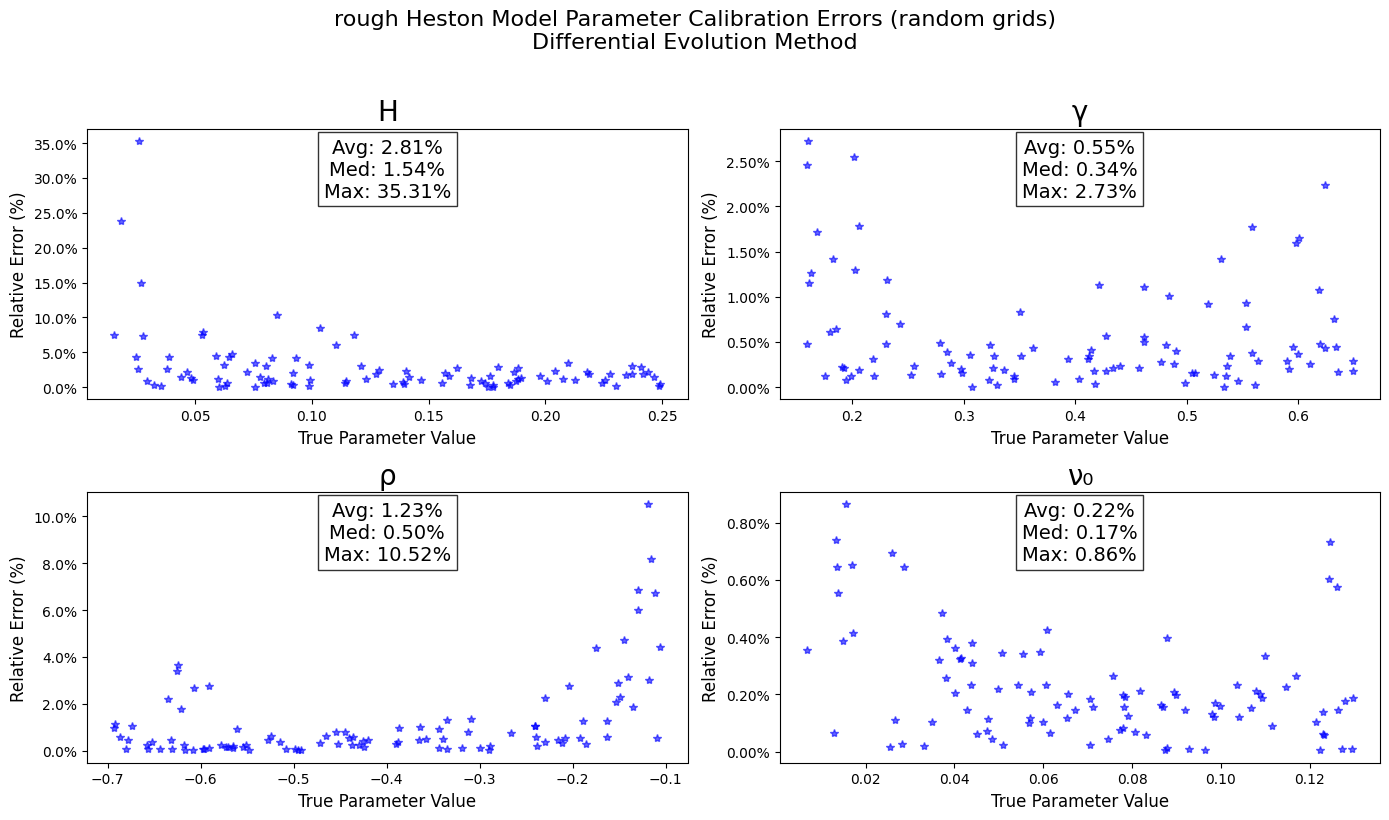


Summary Statistics of Relative Errors (%):
H: Avg=2.81%, Med=1.54%, Max=35.31%
γ: Avg=0.55%, Med=0.34%, Max=2.73%
ρ: Avg=1.23%, Med=0.50%, Max=10.52%
ν₀: Avg=0.22%, Med=0.17%, Max=0.86%


In [19]:
# Extract Differential Evolution parameters (usually the best performing)
DEParameters = solutions_gf[:, 1, :]

# Extract unique Heston parameters from X_test (remove duplicates and strike/maturity columns)
# Since parameters are repeated 143 times for each surface, we take every 143th row
X_test_compare = X_test[::143, :4]  # Take every 143th row and first 4 columns
X_test_compare = X_test_compare[:n_surfaces,:]

# Verify shapes
print(f"Calibrated parameters shape: {DEParameters.shape}")  # Should be (360, 4)
print(f"Test parameters shape: {X_test_compare.shape}")      # Should be (360, 4)

# Verify dimensions
assert len(DEParameters) == len(X_test_compare), "Mismatch between calibrated parameters and test set"

# Plot relative errors for each parameter
titles = ["H", "γ", "ρ", "ν₀"]
relative_errors = np.zeros((len(DEParameters), 4))  # Store all relative errors

fig = plt.figure(figsize=(14, 8))
for param_idx in range(4):
    ax = plt.subplot(2, 2, param_idx+1)
    
    # Get true and calibrated parameters
    true_params = X_test_compare[:, param_idx]
    calibrated_params = DEParameters[:, param_idx]
    
    # Calculate relative errors
    with np.errstate(divide='ignore', invalid='ignore'):
        rel_errors = np.abs(calibrated_params - true_params) / np.abs(true_params)
    
    relative_errors[:, param_idx] = rel_errors
    
    # Plot
    plt.plot(true_params, 100 * rel_errors, 'b*', alpha=0.6)
    plt.title(titles[param_idx], fontsize=20)
    plt.xlabel('True Parameter Value', fontsize=12)
    plt.ylabel('Relative Error (%)', fontsize=12)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    
    # Add statistics
    stats_text = 'Avg: %1.2f%%\nMed: %1.2f%%\nMax: %1.2f%%' % (
        np.mean(100 * rel_errors),
        np.median(100 * rel_errors),
        np.max(100 * rel_errors))
    
    plt.text(0.5, 0.85, stats_text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8))

plt.suptitle('rough Heston Model Parameter Calibration Errors (random grids)\nDifferential Evolution Method', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Additional analysis
print("\nSummary Statistics of Relative Errors (%):")
for i, title in enumerate(titles):
    print(f"{title}: Avg={np.mean(100*relative_errors[:,i]):.2f}%, "
          f"Med={np.median(100*relative_errors[:,i]):.2f}%, "
          f"Max={np.max(100*relative_errors[:,i]):.2f}%")

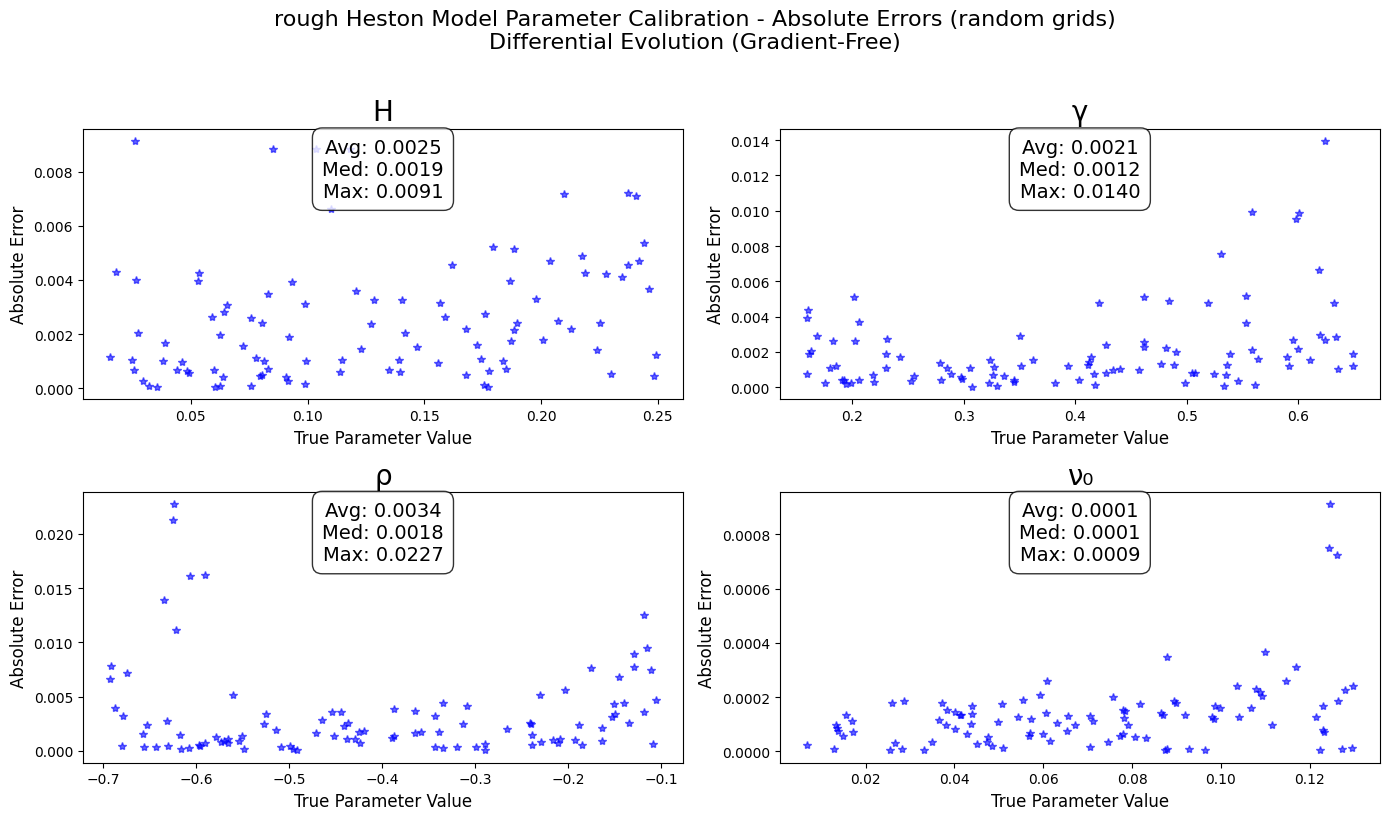


Summary Statistics of Absolute Errors:
H: Avg=0.002477, Med=0.001925, Max=0.009138
γ: Avg=0.002077, Med=0.001243, Max=0.013965
ρ: Avg=0.003360, Med=0.001794, Max=0.022744
ν₀: Avg=0.000136, Med=0.000120, Max=0.000911


In [20]:
# Plot absolute errors for each parameter
titles = ["H", "γ", "ρ", "ν₀"]
absolute_errors = np.zeros((len(DEParameters), 4))  # Store all absolute errors

fig = plt.figure(figsize=(14, 8))
for param_idx in range(4):
    ax = plt.subplot(2, 2, param_idx+1)
    
    # Get true and calibrated parameters
    true_params = X_test_compare[:, param_idx]
    calibrated_params = DEParameters[:, param_idx]
    
    # Calculate absolute errors
    abs_errors = np.abs(calibrated_params - true_params)
    absolute_errors[:, param_idx] = abs_errors
    
    # Plot with consistent style
    plt.plot(true_params, abs_errors, 'b*', alpha=0.6)
    plt.title(titles[param_idx], fontsize=20)
    plt.xlabel('True Parameter Value', fontsize=12)
    plt.ylabel('Absolute Error', fontsize=12)
    
    # Add statistics with consistent formatting
    stats_text = 'Avg: %1.4f\nMed: %1.4f\nMax: %1.4f' % (
        np.mean(abs_errors),
        np.median(abs_errors),
        np.max(abs_errors))
    
    plt.text(0.5, 0.85, stats_text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8,
                      boxstyle='round,pad=0.5'))

plt.suptitle('rough Heston Model Parameter Calibration - Absolute Errors (random grids)\nDifferential Evolution (Gradient-Free)', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Additional analysis with consistent output format
print("\nSummary Statistics of Absolute Errors:")
for i, title in enumerate(titles):
    print(f"{title}: Avg={np.mean(absolute_errors[:,i]):.6f}, "
          f"Med={np.median(absolute_errors[:,i]):.6f}, "
          f"Max={np.max(absolute_errors[:,i]):.6f}")